In [32]:
import requests
import csv
from bs4 import BeautifulSoup
import time
from collections import Counter, defaultdict
import os
import urllib3
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [3]:
target_brands = ["BMW", "Ford", "Volkswagen", "Volvo", "Toyota", "Renault"]

url = 'https://www.cars-data.com'

response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')

row_div = soup.find('div', class_='row center')

links = row_div.find_all('a')

csv_data = []

for link in links:
    brand_name = link.get_text(strip=True)
    link_url = link.get('href') 
    
    if brand_name in target_brands and "facebook" not in link_url:
        csv_data.append([brand_name, link_url])

with open('car_data/car_brands.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Brand Name', 'URL'])
    writer.writerows(csv_data)

print("CSV dosyası başarıyla yazıldı.")

CSV dosyası başarıyla yazıldı.


In [ ]:
print("Markalar CSV dosyasını okuyorum...")
brands_data = []
with open('car_data/car_brands.csv', newline='', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
        brand_name = row[0]
        brand_url = row[1]
        
        if 'facebook.com' not in brand_url:
            brands_data.append({"brand_name": brand_name, "url": brand_url})

print(f"{len(brands_data)} marka verisi okundu.")

models_data = []

for brand in brands_data:
    brand_name = brand["brand_name"]
    brand_url = brand["url"]
    
    response = requests.get(brand_url)
    
    soup = BeautifulSoup(response.text, 'html.parser')
    
    print(f"{brand_name} markasının modelleri")
    models_section = soup.find_all('div', class_='col-4')
    
    for model_div in models_section:
        model_link = model_div.find('a')
        if model_link:
            model_url = model_link.get('href') 
            model_name = model_link.get('title')
            
            if 'facebook.com' not in model_url:
                full_url = model_url if model_url else ''
                models_data.append([brand_name, model_name, full_url])
    
    time.sleep(1)
    print(f"{brand_name} markası için modeller alındı. {len(models_data)} model verisi toplandı.")

with open('car_data/car_models.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Brand Name', 'Model Name', 'Model URL'])  # Başlık satırı
    writer.writerows(models_data)  # Verileri yaz

print("CSV dosyası başarıyla yazıldı.")

Markalar CSV dosyasını okuyorum...
6 marka verisi okundu.
BMW markasının modelleri
BMW markası için modeller alındı. 48 model verisi toplandı.
Ford markasının modelleri
Ford markası için modeller alındı. 114 model verisi toplandı.
Renault markasının modelleri
Renault markası için modeller alındı. 184 model verisi toplandı.
Toyota markasının modelleri
Toyota markası için modeller alındı. 264 model verisi toplandı.
Volkswagen markasının modelleri
Volkswagen markası için modeller alındı. 334 model verisi toplandı.
Volvo markasının modelleri
Volvo markası için modeller alındı. 382 model verisi toplandı.
CSV dosyası başarıyla yazıldı.


In [12]:
models_data = []
with open('car_data/car_models.csv', newline='', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
        brand_name = row[0]
        model_name = row[1]
        model_url = row[2]
        models_data.append([brand_name, model_name, model_url])

print(f"{len(models_data)} model verisi okundu.")

model_links_data = []

seen_info = set()
start_index = 0
if os.path.exists("last_processed_index.txt"):
    with open("last_processed_index.txt", "r") as f:
        start_index = int(f.read().strip())
    print(f"Kaldığı yerden devam ediliyor: {start_index + 1}. modelden başlıyor.")

for index, model in enumerate(models_data[start_index:], start=start_index):
    brand_name = model[0]
    model_name = model[1]
    model_url = model[2]

    try:
        response = requests.get(model_url)
        
        soup = BeautifulSoup(response.text, 'html.parser')

        sections = soup.find_all('section', class_='models')
        if len(sections) > 1:
            section = sections[-1] 
            row_div = section.find_all('div', class_='col-4')

            for div in row_div:
                links = div.find_all('a')
                for link in links:
                    model_link = link.get('href')
                    model_title = link.get('title')

                    if model_link and model_title and 'facebook' not in model_link:
                        full_url = f"https://www.cars-data.com{model_link}"
                        
                        if model_title not in seen_info:
                            model_links_data.append([brand_name, model_name.replace(brand_name + ' ', ''), model_title.replace(model_name + ' ', ''), full_url])
                            seen_info.add(model_title) 
                            print(f"Veri Çekildi: {model_title} - {full_url}")

        file_exists = os.path.exists('car_data/model_links.csv')
        with open('car_data/model_links.csv', 'a', newline='', encoding='utf-8') as csvfile:
            writer = csv.writer(csvfile)
            if not file_exists:
                writer.writerow(['Brand Name', 'Model Name', 'Info', 'URL']) 
            writer.writerows(model_links_data) 

        with open("last_processed_index.txt", "w") as f:
            f.write(str(index + 1))
        print(f"{index + 1}. model bağlantısı CSV dosyasına yazıldı.")
        
        model_links_data = []

    except Exception as e:
        print(f"Hata oluştu: {e}")

    time.sleep(1)

if model_links_data:
    print(f"Son {len(model_links_data)} model bağlantısı CSV dosyasına yazılıyor...")
    with open('car_data/model_links.csv', 'a', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(model_links_data) 
    print("CSV dosyasına veri başarıyla eklendi.")

print("Tüm işlemler tamamlandı.")

print("Model bağlantıları gruplanıyor...")

info_count = Counter()
with open('car_data/model_links.csv', newline='', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile)
    next(reader) 
    for row in reader:
        info = row[2] 
        info_count[info] += 1

print("Info kategorilerine göre sayılar:")
for info, count in info_count.items():
    print(f"{info}: {count} tane")

382 model verisi okundu.
Kaldığı yerden devam ediliyor: 98. modelden başlıyor.
Veri Çekildi: Ford Maverick SWB Maintenance - https://www.cars-data.com/en/ford-maverick-swb/maintenance
Veri Çekildi: Ford Maverick SWB Rear brakes - https://www.cars-data.com/en/ford-maverick-swb/rear-brakes
Veri Çekildi: Ford Maverick SWB Ground clearance - https://www.cars-data.com/en/ford-maverick-swb/ground-clearance
Veri Çekildi: Ford Maverick SWB Power kw - https://www.cars-data.com/en/ford-maverick-swb/power-kw
Veri Çekildi: Ford Maverick SWB Bore x stroke - https://www.cars-data.com/en/ford-maverick-swb/bore-x-stroke
Veri Çekildi: Ford Maverick SWB Drive wheel - https://www.cars-data.com/en/ford-maverick-swb/drive-wheel
Veri Çekildi: Ford Maverick SWB Front interior width - https://www.cars-data.com/en/ford-maverick-swb/front-interior-width
Veri Çekildi: Ford Maverick SWB Price - https://www.cars-data.com/en/ford-maverick-swb/price
Veri Çekildi: Ford Maverick SWB Power hp - https://www.cars-data.co

In [18]:
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

motor_kategorileri = [
    "Engine motor type",
    "Engine capacity",
    "Power",
    "Power kw",
    "Power hp",
    "Max torque",
    "Fuel type",
    "Fuel system",
    "Fuel tank capacity",
    "Fuel costs",
    "Fuel consumption",
    "Compression ratio"
]

model_links_data = []

with open('car_data/model_links.csv', newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        model_links_data.append(row)

info_dict = defaultdict(list)
for row in model_links_data:
    info_dict[row['Info']].append(row)

for info, links in info_dict.items():
    if info in motor_kategorileri:
        print(f"{info} kategorisi için veriler çekiliyor...")

        result_data = []

        output_file = f'car_data/info_datas/{info}_data.csv'
        is_new_file = not os.path.exists(output_file)

        for link in links:
            brand_name = link['Brand Name']
            model_name = link['Model Name']
            model_url = link['URL']

            try:
                response = requests.get(model_url, verify=False)  
                
                response.raise_for_status()

                soup = BeautifulSoup(response.text, 'html.parser')

                table = soup.find('table', id='models')
                if table:
                    headers = [header.text.strip() for header in table.find_all('th')]

                    rows = table.find_all('tr')
                    for row in rows[1:]: 
                        cols = row.find_all('td')
                        if len(cols) == len(headers):  
                            data = [col.text.strip() for col in cols]
                            
                            result_data.append([brand_name, model_name, info] + data)

                with open(output_file, 'a', newline='', encoding='utf-8') as csvfile:
                    writer = csv.writer(csvfile)
                    
                    if is_new_file:
                        writer.writerow(['Brand Name', 'Model Name', 'Info'] + headers)
                        is_new_file = False 

                    writer.writerows(result_data)
                    print(f"{model_name} verileri başarıyla yazıldı.")

                result_data = []

            except requests.exceptions.RequestException as e:
                print(f"HTTP Hatası oluştu: {e}")
            except Exception as e:
                print(f"Beklenmedik bir hata oluştu: {e}")

            time.sleep(1)

print("Tüm işlemler tamamlandı.")


Engine motor type kategorisi için veriler çekiliyor...
2-series Gran Coupe verileri başarıyla yazıldı.
8-series Cabrio verileri başarıyla yazıldı.
X7 verileri başarıyla yazıldı.
i8 Roadster verileri başarıyla yazıldı.
2-series Cabrio verileri başarıyla yazıldı.
2-series Coupe verileri başarıyla yazıldı.
4-series Gran Coupe verileri başarıyla yazıldı.
X4 verileri başarıyla yazıldı.
i8 verileri başarıyla yazıldı.
4-series Coupe verileri başarıyla yazıldı.
X1 verileri başarıyla yazıldı.
5-series Gran Turismo verileri başarıyla yazıldı.
1-series verileri başarıyla yazıldı.
Z8 verileri başarıyla yazıldı.
5-series Touring verileri başarıyla yazıldı.
8-series verileri başarıyla yazıldı.
7-series verileri başarıyla yazıldı.
3-series verileri başarıyla yazıldı.
6-series verileri başarıyla yazıldı.
Tourneo Courier verileri başarıyla yazıldı.
Focus Electric verileri başarıyla yazıldı.
Tourneo Custom verileri başarıyla yazıldı.
B-MAX verileri başarıyla yazıldı.
Transit Custom Kombi verileri başarı

KeyboardInterrupt: 

In [21]:

folder_path = 'car_data/info_datas'

csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

common_columns = ['Brand Name', 'Model Name', 'Model', 'Year', 'Body Type', 'Fuel Type', 'Transmission', 'Power']

dfs = []

for file in csv_files:
    df = pd.read_csv(os.path.join(folder_path, file))
    
    df_cleaned = df[common_columns + [col for col in df.columns if col not in common_columns and col != 'Info']]
    
    dfs.append(df_cleaned)

final_df = dfs[0]

for df in dfs[1:]:
    final_df = pd.merge(final_df, df, on=common_columns, how='outer')

final_df = final_df.loc[:, ~final_df.columns.duplicated()]

print(final_df.head())
final_df.to_csv('car_data/combined_data.csv', index=False)


  Brand Name Model Name         Model  Year  Body Type Fuel Type Transmission  \
0        BMW   1-series  BMW 1-series  2004  Hatchback    Petrol       Manual   
1        BMW   1-series  BMW 1-series  2005  Hatchback    Petrol       Manual   
2        BMW   1-series  BMW 1-series  2006  Hatchback    Petrol       Manual   
3        BMW   1-series  BMW 1-series  2007  Hatchback    Petrol       Manual   
4        BMW   1-series  BMW 1-series  2007  Hatchback    Petrol       Manual   

    Power Engine capacity Fuel-system Power (kW) Fuel tank capacity  \
0  115 hp         1596 cc         NaN        NaN                NaN   
1  129 hp         1995 cc         NaN        NaN                NaN   
2  115 hp         1596 cc         NaN        NaN                NaN   
3  115 hp         1596 cc         NaN        NaN                NaN   
4  122 hp         1597 cc         NaN        NaN                NaN   

  Compression-ratio Engine/motor type Fuel type Max torque Fuel costs  \
0            

In [22]:
df = pd.read_csv('car_data/combined_data.csv')

numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])

df.to_csv('car_data/combined_data_filled.csv', index=False)

print("Boş hücreler dolduruldu. Yeni dosya 'combined_data_filled.csv' olarak kaydedildi.")
print(df.head())


/tmp/ipykernel_615/1946944254.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('car_data/combined_data.csv')


Boş hücreler dolduruldu. Yeni dosya 'combined_data_filled.csv' olarak kaydedildi.
  Brand Name Model Name         Model  Year  Body Type Fuel Type Transmission  \
0        BMW   1-series  BMW 1-series  2004  Hatchback    Petrol       Manual   
1        BMW   1-series  BMW 1-series  2005  Hatchback    Petrol       Manual   
2        BMW   1-series  BMW 1-series  2006  Hatchback    Petrol       Manual   
3        BMW   1-series  BMW 1-series  2007  Hatchback    Petrol       Manual   
4        BMW   1-series  BMW 1-series  2007  Hatchback    Petrol       Manual   

    Power Engine capacity           Fuel-system Power (kW) Fuel tank capacity  \
0  115 hp         1596 cc  multipoint injection         55               55 l   
1  129 hp         1995 cc  multipoint injection         55               55 l   
2  115 hp         1596 cc  multipoint injection         55               55 l   
3  115 hp         1596 cc  multipoint injection         55               55 l   
4  122 hp         1597 cc 

In [25]:
df = pd.read_csv('car_data/combined_data_filled.csv', low_memory=False)
if 'Info' in df.columns:
    df.drop(['Info'], axis=1, inplace=True)

df['Power (hp)'] = df['Power'].str.extract(r'(\d+)').astype(float)
df['Power (kW)'] = df['Power.1'].str.extract(r'(\d+)').astype(float)

df['Engine capacity'] = df['Engine capacity'].str.extract(r'(\d+)').astype(float)

df['Compression-ratio'] = df['Compression-ratio'].str.replace(",", ".").str.extract(r'(\d+\.\d+|\d+)').astype(float)

df['Fuel tank capacity'] = df['Fuel tank capacity'].str.extract(r'(\d+\.\d+|\d+)').astype(float)

df.fillna(df.mean(numeric_only=True), inplace=True)

df['Transmission'] = df['Transmission'].astype('category').cat.codes
df['Fuel Type'] = df['Fuel Type'].astype('category').cat.codes

numeric_columns = ['Year', 'Power (hp)', 'Power (kW)', 'Engine capacity', 
                   'Fuel tank capacity', 'Compression-ratio']

scaler = StandardScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

print(df.head())

df.to_csv('car_data/combined_data_processed.csv', index=False)

print("İşlenmiş veri başarıyla 'combined_data_processed.csv' dosyasına kaydedildi.")

  Brand Name Model Name         Model      Year  Body Type  Fuel Type  \
0        BMW   1-series  BMW 1-series -0.045480  Hatchback          7   
1        BMW   1-series  BMW 1-series  0.087649  Hatchback          7   
2        BMW   1-series  BMW 1-series  0.220778  Hatchback          7   
3        BMW   1-series  BMW 1-series  0.353908  Hatchback          7   
4        BMW   1-series  BMW 1-series  0.353908  Hatchback          7   

   Transmission   Power  Engine capacity           Fuel-system  Power (kW)  \
0             1  115 hp         1.502940  multipoint injection   -0.187285   
1             1  129 hp         3.724022  multipoint injection   -0.187285   
2             1  115 hp         1.502940  multipoint injection   -0.187285   
3             1  115 hp         1.502940  multipoint injection   -0.187285   
4             1  122 hp         1.508507  multipoint injection   -0.187285   

   Fuel tank capacity  Compression-ratio Engine/motor type Fuel type  \
0             0.0985

In [26]:
# Veri setini yükleme
df = pd.read_csv('combined_data_processed.csv', low_memory=False)

# Eğer 'Info' sütunu varsa kaldır
if 'Info' in df.columns:
    df.drop(['Info'], axis=1, inplace=True)

# Sayısal sütunları kontrol etme ve dönüştürme
numeric_columns = ['Year', 'Power', 'Engine capacity', 'Fuel tank capacity', 'Compression-ratio', 'Power (hp)', 'Power (kW)']

# Sayısal olmayan değerleri temizleme
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Sayısal olmayan değerleri NaN'ye dönüştürür

# Sadece sayısal sütunlardaki eksik değerleri ortalama ile doldurma
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

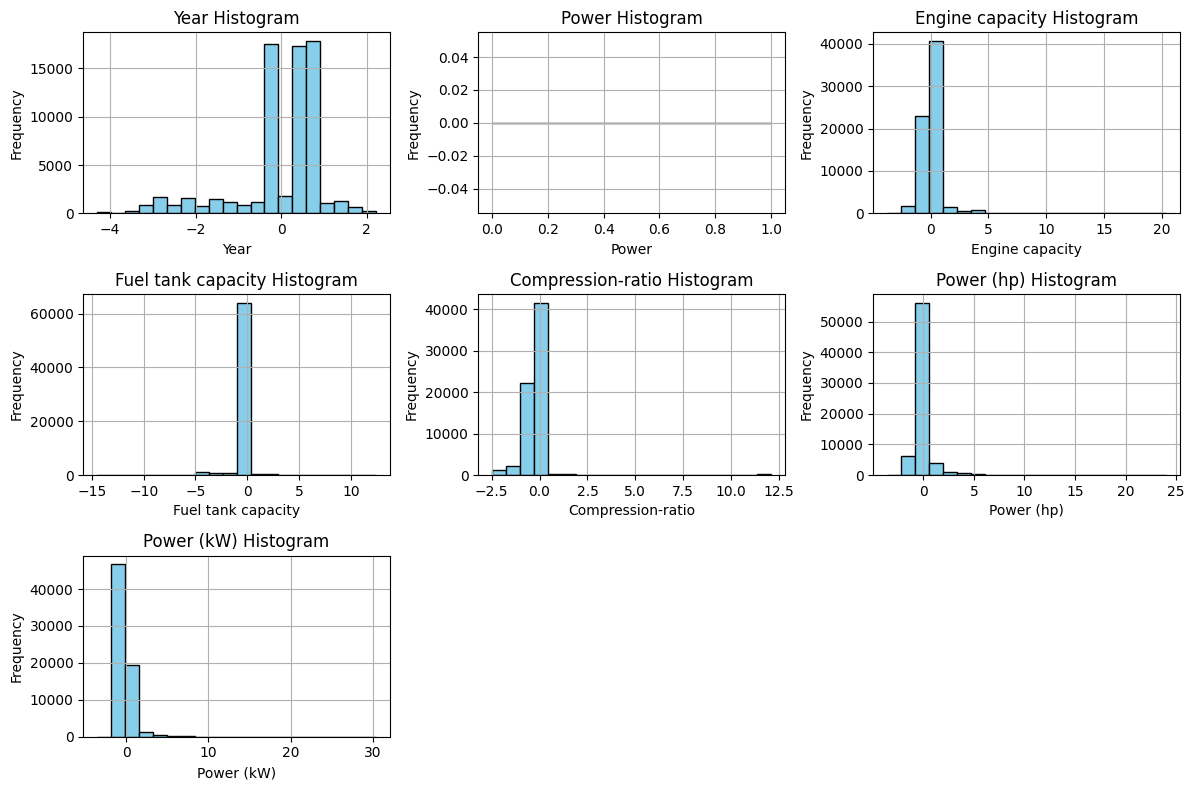

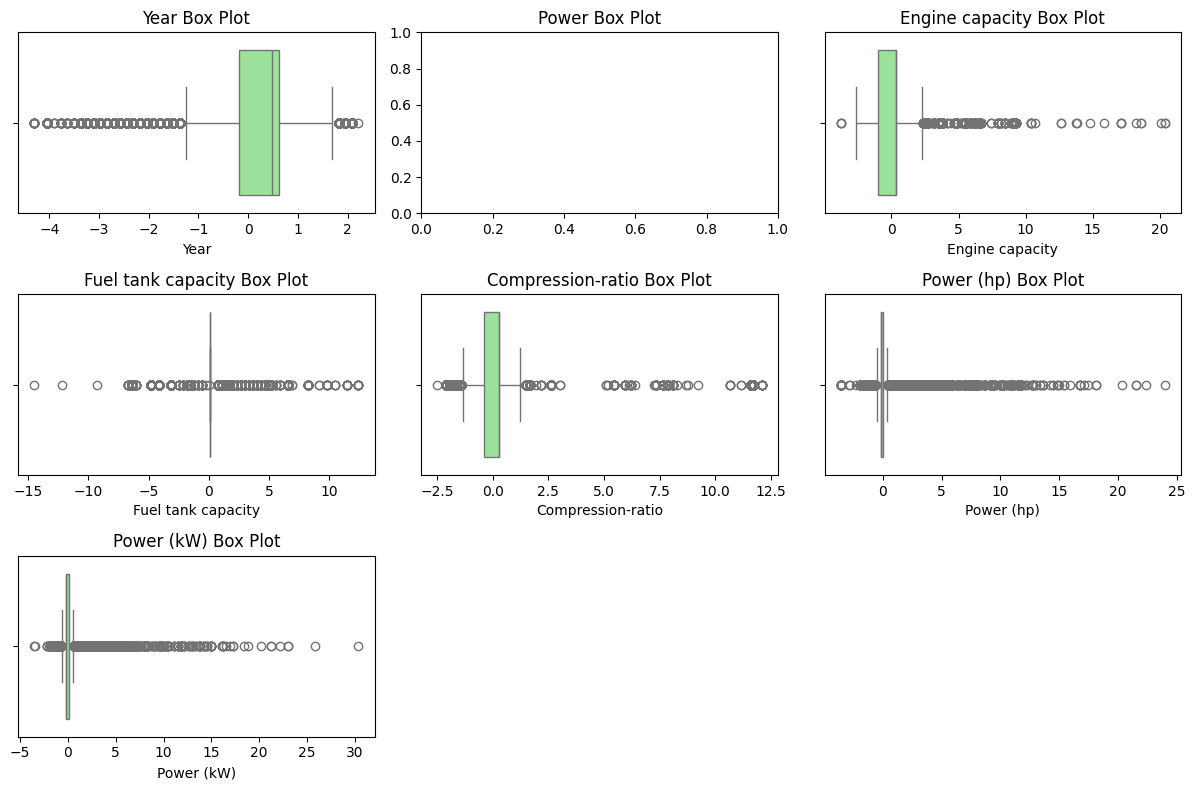

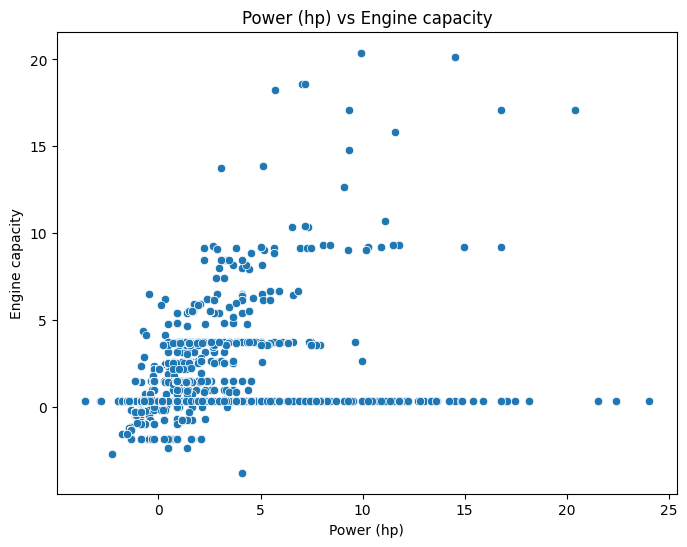

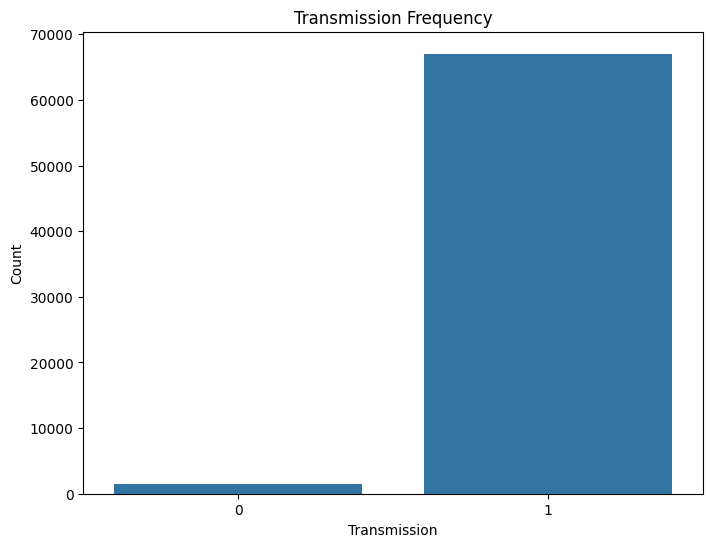

In [28]:
numeric_columns = ['Year', 'Power', 'Engine capacity', 'Fuel tank capacity', 'Compression-ratio', 'Power (hp)', 'Power (kW)']

plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 3, i)  
    df[col].dropna().hist(bins=20, color='skyblue', edgecolor='black')
    plt.title(f'{col} Histogram')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col].dropna(), color='lightgreen') 
    plt.title(f'{col} Box Plot')

plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 6))
sns.scatterplot(x='Power (hp)', y='Engine capacity', data=df)
plt.title('Power (hp) vs Engine capacity')
plt.xlabel('Power (hp)')
plt.ylabel('Engine capacity')
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x='Transmission', data=df)
plt.title('Transmission Frequency')
plt.xlabel('Transmission')
plt.ylabel('Count')
plt.show()

In [30]:
manual_power = df[df['Transmission'] == 0]['Power (hp)'] 
auto_power = df[df['Transmission'] == 1]['Power (hp)']   

t_stat, p_value = stats.ttest_ind(manual_power.dropna(), auto_power.dropna()) 

print("t-Testi Sonuçları:")
print(f"T-istatistiği: {t_stat}")
print(f"P-değeri: {p_value}")

alpha = 0.05 
if p_value < alpha:
    print("Sonuç: Şanzıman türleri arasında anlamlı bir fark var.")
else:
    print("Sonuç: Şanzıman türleri arasında anlamlı bir fark yok.")


t-Testi Sonuçları:
T-istatistiği: 102.53009047011764
P-değeri: 0.0
Sonuç: Şanzıman türleri arasında anlamlı bir fark var.


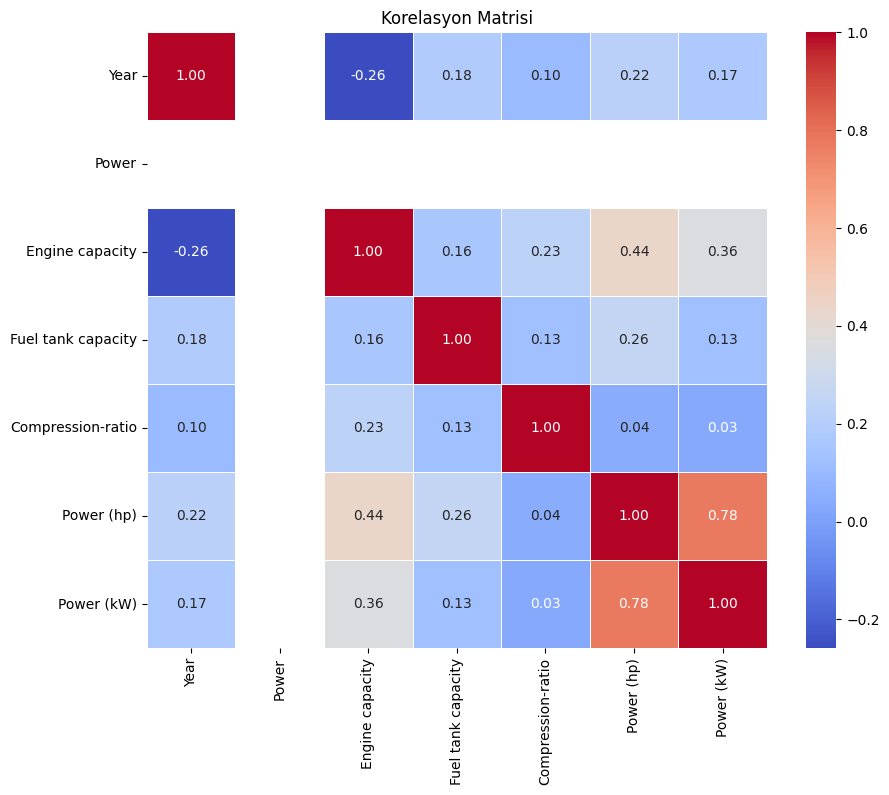

In [31]:
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Korelasyon Matrisi")
plt.show()

In [33]:
X = df[['Engine capacity', 'Fuel tank capacity', 'Compression-ratio', 'Year', 'Power (kW)']]
y = df['Power (hp)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Tahmin yapma
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Sonuçları yazdırma
print(f"Ortalama Kare Hatası (MSE): {mse:.2f}")
print(f"R-kare (R2) Skoru: {r2:.2f}")

# Regresyon katsayıları
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Katsayı'])
print("\nRegresyon Katsayıları:")
print(coefficients)

Ortalama Kare Hatası (MSE): 0.30
R-kare (R2) Skoru: 0.68

Regresyon Katsayıları:
                     Katsayı
Engine capacity     0.242027
Fuel tank capacity  0.116453
Compression-ratio  -0.064260
Year                0.158672
Power (kW)          0.652046
